# Diabetes in 130 US hospitals for the years 1999 to 2008

## Checking algorithms

 * [Feature selection](#Feature-selection)
   - [Recursive feature elimination](#Recursive-feature-elimination)
 * [Logistic regression](#Logistic-regression)
   - [statsmodels](#statsmodels)
   - [scikit-learn](#scikit-learn)
     - [Confusion matrix](#Confusion-matrix)
     - [Precision, recall, F measure and support](#Precision,-recall,-F-measure-and-support)
     - [ROC curve](#ROC-curve)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
df_encoded = pd.read_csv('data/df_encoded.csv', index_col=0)

In [4]:
df_encoded.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,race=Caucasian,gender=Female,age=[10-20),max_glu_serum=None,A1Cresult=None,metformin=No,repaglinide=No,nateglinide=No,chlorpropamide=No,glimepiride=No,acetohexamide=No,glipizide=No,glyburide=No,tolbutamide=No,pioglitazone=No,rosiglitazone=No,acarbose=No,miglitol=No,troglitazone=No,tolazamide=No,examide=No,citoglipton=No,insulin=Up,glyburide-metformin=No,glipizide-metformin=No,glimepiride-pioglitazone=No,metformin-rosiglitazone=No,metformin-pioglitazone=No,change=Ch,diabetesMed=Yes,primary_diag=Others,secondary_diag=Diabetes,additional_diag=Others,race=AfricanAmerican,age=[20-30),glipizide=Steady,insulin=No,change=No,secondary_diag=Others,gender=Male,age=[30-40),additional_diag=Circulatory,age=[40-50),insulin=Steady,primary_diag=Neoplasms,secondary_diag=Neoplasms,age=[50-60),primary_diag=Circulatory,secondary_diag=Circulatory,age=[60-70),metformin=Steady,glimepiride=Steady,age=[70-80),glyburide=Steady,secondary_diag=Respiratory,age=[80-90),age=[90-100),rosiglitazone=Steady,additional_diag=Respiratory,primary_diag=Diabetes,additional_diag=Injury,glyburide=Up,additional_diag=Neoplasms,repaglinide=Up,insulin=Down,additional_diag=Diabetes,primary_diag=Respiratory,secondary_diag=Injury,additional_diag=Genitourinary,primary_diag=Injury,diabetesMed=No,secondary_diag=Musculoskeletal,race=Other,A1Cresult=>7,secondary_diag=Genitourinary,acarbose=Steady,primary_diag=Genitourinary,secondary_diag=Digestive,metformin=Up,additional_diag=Digestive,troglitazone=Steady,primary_diag=Musculoskeletal,primary_diag=Digestive,A1Cresult=>8,A1Cresult=Norm,repaglinide=Steady,additional_diag=Musculoskeletal,max_glu_serum=>300,glipizide=Up,max_glu_serum=Norm,max_glu_serum=>200,glipizide=Down,race=Asian,race=Hispanic,repaglinide=Down,age=[0-10),rosiglitazone=Up,glimepiride=Down,glimepiride=Up,tolazamide=Steady,pioglitazone=Steady,pioglitazone=Up,metformin=Down,glyburide=Down,tolbutamide=Steady,chlorpropamide=Steady,pioglitazone=Down,acarbose=Up,rosiglitazone=Down,glyburide-metformin=Steady,nateglinide=Steady,chlorpropamide=Down,chlorpropamide=Up,glyburide-metformin=Down,miglitol=Steady,glyburide-metformin=Up,nateglinide=Down,acetohexamide=Steady,miglitol=Down,nateglinide=Up,glipizide-metformin=Steady,miglitol=Up,metformin-pioglitazone=Steady
0,3,59,0,18,0,0,0,9,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2,11,5,13,2,0,1,6,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,2,44,1,16,0,0,0,7,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1,51,0,8,0,0,0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.

In [5]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68629 entries, 0 to 68628
Columns: 132 entries, time_in_hospital to metformin-pioglitazone=Steady
dtypes: float64(123), int64(9)
memory usage: 69.6 MB


In [6]:
df_encoded.shape

(68629, 132)

## Remove `Others` category from medical condition categories

In [7]:
others_col_to_drop = list(df_encoded.columns[df_encoded.columns.str.contains('Others')])
df_encoded.drop(others_col_to_drop, axis=1, inplace=True)

In [8]:
df_encoded.shape

(68629, 129)

## Recursive feature elimination

We're going to perform [feature ranking with recursive feature elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), using the RFE class in scikit-learn. This procedure was taken from this blog post ['Building A Logistic Regression in Python, Step by Step'](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8). As the blog post mentions, this technique _"is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features."_

In [9]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [10]:
X = df_encoded.drop('readmitted', axis=1)
y = df_encoded.loc[:, 'readmitted'].values.ravel()
print(f'Dimensions of X: {X.shape}')
print(f'Dimensions of y: {y.shape}')

Dimensions of X: (68629, 128)
Dimensions of y: (68629,)


The `readmitted` output column has a fairly similar amount of readmission and non-readmission cases.

In [11]:
print(f'Ratio of readmission to total: {(y == 1).sum()/y.shape[0]:.2f}')
print(f'Ratio of non-readmission to total: {(y == 0).sum()/y.shape[0]:.2f}')

Ratio of readmission to total: 0.40
Ratio of non-readmission to total: 0.60


In [30]:
from time import time
t0 = time()
lg = LogisticRegression(solver='newton-cg')
rfe = RFE(lg, n_features_to_select=20)
rfe.fit(X, y)
print(f'Time elapsed: {time() - t0:.2f} sec.')

Time elapsed: 416.27 sec.


In [31]:
print(f'Number of reduced features: {rfe.n_features_}')
print(f'List of reduced features: {list(X.columns.values[rfe.support_])}')

Number of reduced features: 20
List of reduced features: ['number_inpatient', 'A1Cresult=None', 'nateglinide=No', 'chlorpropamide=No', 'troglitazone=No', 'examide=No', 'race=AfricanAmerican', 'age=[50-60)', 'glimepiride=Steady', 'age=[70-80)', 'glyburide=Steady', 'secondary_diag=Respiratory', 'acarbose=Steady', 'primary_diag=Musculoskeletal', 'primary_diag=Digestive', 'race=Asian', 'rosiglitazone=Up', 'tolbutamide=Steady', 'nateglinide=Up', 'miglitol=Up']


In [32]:
X_mod = X.loc[:, list(X.columns.values[rfe.support_])]

In [33]:
print(X_mod.shape)
print(y.shape)

(68629, 20)
(68629,)


Saving model with `joblib` from `scikit-learn`.

In [36]:
from sklearn.externals import joblib
joblib.dump(rfe, 'rfe_model.sav')

['rfe_model.sav']

# Logistic regression

## statsmodels

We now determine the features that give the most significant contribution to our analysis.

In [16]:
import statsmodels.api as sm
logit_model = sm.Logit(y, X_mod)
result = logit_model.fit_regularized(method='l1')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6630469146132226
            Iterations: 169
            Function evaluations: 169
            Gradient evaluations: 169


In [17]:
display(result.summary2())

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Logit
=========================================================================================
Model:                      Logit                    Pseudo R-squared:         0.017     
Dependent Variable:         y                        AIC:                      91048.4934
Date:                       2019-07-29 15:03         BIC:                      91231.2228
No. Observations:           68629                    Log-Likelihood:           -45504.   
Df Model:                   19                       LL-Null:                  -46306.   
Df Residuals:               68609                    LLR p-value:              0.0000    
Converged:                  1.0000                   Scale:                    1.0000    
No. Iterations:             169.0000                                                     
-----------------------------------------------------------------------------------------
                              Coef.    Std.Err.     z     P>|z|     [0.025       0.975]  
-----------------------------------------------------------------------------------------
number_inpatient              0.5188      0.0153  33.8781 0.0000       0.4888      0.5488
A1Cresult=None               -0.4692      0.1442  -3.2536 0.0011      -0.7518     -0.1866
nateglinide=No               -0.5209 159414.1376  -0.0000 1.0000 -312446.4892 312445.4474
chlorpropamide=No             1.6181 159414.1376   0.0000 1.0000 -312444.3503 312447.5864
troglitazone=No              -0.9452      0.3113  -3.0366 0.0024      -1.5552     -0.3351
examide=No                   -0.3850      0.0689  -5.5876 0.0000      -0.5200     -0.2499
race=AfricanAmerican          1.8217      1.3926   1.3081 0.1908      -0.9078      4.5511
age=[50-60)                   0.6680      0.7626   0.8760 0.3810      -0.8266      2.1626
glimepiride=Steady           -1.9588 159414.1376  -0.0000 1.0000 -312447.9272 312444.0096
age=[70-80)                   1.9527 159414.1376   0.0000 1.0000 -312444.0156 312447.9210
glyburide=Steady              2.0892 159414.1376   0.0000 1.0000 -312443.8791 312448.0574
secondary_diag=Respiratory    0.7078 159414.1376   0.0000 1.0000 -312445.2605 312446.6760
acarbose=Steady              -1.0654      0.4692  -2.2708 0.0232      -1.9850     -0.1458
primary_diag=Musculoskeletal -0.4964      0.5716  -0.8684 0.3852      -1.6168      0.6240
primary_diag=Digestive        0.5188      0.2310   2.2462 0.0247       0.0661      0.9715
race=Asian                   -0.4346      0.0434 -10.0190 0.0000      -0.5196     -0.3496
rosiglitazone=Up             -0.4488      0.1001  -4.4832 0.0000      -0.6451     -0.2526
tolbutamide=Steady           -0.4995      0.2604  -1.9185 0.0550      -1.0099      0.0108
nateglinide=Up                0.5624      0.5283   1.0645 0.2871      -0.4731      1.5979
miglitol=Up                  -0.9190      1.1854  -0.7753 0.4382      -3.2423      1.4042
=========================================================================================

"""

There are 12 feature that have a p value greater than 0.05, and these are: `nateglinide=No`, `chlorpropamide=No`, `race=AfricanAmerican`, `age=[50-60)`, `glimepiride=Steady`, `age=[70-80)`, `glyburide=Steady`, `secondary_diag=Respiratory`, `primary_diag=Musculoskeletal`, `tolbutamide=Steady`, `nateglinide=Up` and `miglitol=Up`. We remove these column from the analysis.

In [37]:
removed_cols = ['nateglinide=No', 'chlorpropamide=No', 'race=AfricanAmerican', 'age=[50-60)', 
                'glimepiride=Steady', 'age=[70-80)', 'glyburide=Steady', 'secondary_diag=Respiratory', \
                'primary_diag=Musculoskeletal', 'tolbutamide=Steady', 'nateglinide=Up', 'miglitol=Up']

In [38]:
columns_to_keep = list(set(X_mod.columns) - set(removed_cols))
print(f'Final set of features to be used for analysis: {columns_to_keep}')
X_mod_after_rfe = X_mod[columns_to_keep]

Final set of features to be used for analysis: ['A1Cresult=None', 'examide=No', 'race=Asian', 'troglitazone=No', 'primary_diag=Digestive', 'acarbose=Steady', 'number_inpatient', 'rosiglitazone=Up']


In [39]:
logit_model_after_rfe = sm.Logit(y, X_mod_after_rfe)
result_after_rfe = logit_model_after_rfe.fit_regularized(method='l1')
display(result_after_rfe.summary2())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6632094463513283
            Iterations: 73
            Function evaluations: 73
            Gradient evaluations: 73


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.017     
Dependent Variable:   y                  AIC:                91046.8022
Date:                 2019-07-29 16:31   BIC:                91119.8940
No. Observations:     68629              Log-Likelihood:     -45515.   
Df Model:             7                  LL-Null:            -46306.   
Df Residuals:         68621              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       73.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
A1Cresult=None         -0.3723   0.1375  -2.7077 0.0068 -0.6418 -0.1028
examide=No             -0.3860   0.0689  -5.6028 0.0000 -0.5210 -0.2509
race=Asian             -0.4338   0.0434 -10.0009 0.0000 -0.5188 -0.3487
troglitazone=No        -0.9487   0.3115  -3.0454 0.0023 -1.5593 -0.3381
primary_diag=Digestive  0.5191   0.2310   2.2473 0.0246  0.0664  0.9717
acarbose=Steady        -0.0865   0.1373  -0.6301 0.5286 -0.3557  0.1826
number_inpatient        0.5184   0.0153  33.8577 0.0000  0.4884  0.5484
rosiglitazone=Up       -0.4462   0.1001  -4.4571 0.0000 -0.6424 -0.2500
=======================================================================

"""

After the new feature set, there is still a feature called `acarbose=Steady` that has a high p value (`p=0.529`). We remove this feature as well.

In [40]:
removed_cols = removed_cols + ['acarbose=Steady']
columns_to_keep = list(set(X_mod.columns) - set(removed_cols))
print(f'Final set of features to be used for analysis: {columns_to_keep}')
X_mod_after_rfe_second = X_mod[columns_to_keep]

Final set of features to be used for analysis: ['A1Cresult=None', 'examide=No', 'race=Asian', 'troglitazone=No', 'primary_diag=Digestive', 'number_inpatient', 'rosiglitazone=Up']


In [41]:
logit_model_after_rfe_second = sm.Logit(y, X_mod_after_rfe_second)
result_after_rfe_second = logit_model_after_rfe_second.fit_regularized(method='l1')
display(result_after_rfe_second.summary2())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6632123360893142
            Iterations: 63
            Function evaluations: 63
            Gradient evaluations: 63


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.017     
Dependent Variable:   y                  AIC:                91045.1988
Date:                 2019-07-29 16:31   BIC:                91109.1541
No. Observations:     68629              Log-Likelihood:     -45516.   
Df Model:             6                  LL-Null:            -46306.   
Df Residuals:         68622              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       63.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
A1Cresult=None         -0.4588   0.0085 -53.9935 0.0000 -0.4754 -0.4421
examide=No             -0.3860   0.0689  -5.6032 0.0000 -0.5210 -0.2510
race=Asian             -0.4339   0.0434 -10.0053 0.0000 -0.5189 -0.3489
troglitazone=No        -0.9487   0.3115  -3.0453 0.0023 -1.5592 -0.3381
primary_diag=Digestive  0.5191   0.2310   2.2477 0.0246  0.0665  0.9718
number_inpatient        0.5183   0.0153  33.8541 0.0000  0.4882  0.5483
rosiglitazone=Up       -0.4466   0.1001  -4.4615 0.0000 -0.6428 -0.2504
=======================================================================

"""

## scikit-learn

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_mod_after_rfe_second, y, test_size = 0.2, random_state=42)

In [43]:
print(f'X_train: {X_train.shape}\nX_test: {X_test.shape}\ny_train: {y_train.shape}\ny_test: {y_test.shape}')

X_train: (54903, 7)
X_test: (13726, 7)
y_train: (54903,)
y_test: (13726,)


In [44]:
clf = LogisticRegression(solver='newton-cg').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'Accuracy of logistic regression classifier on test set: {clf.score(X_test, y_test):.3f}')

Accuracy of logistic regression classifier on test set: 0.623


### Confusion matrix

As explained in scikit-learn at ['sklearn.metrics.confusion_matrix'](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html):

 - a confusion matrix `C` is such that `C[i, j]` is equal to the number of observations known to be in group `i` but predicted to be in group `j`.

Thus in binary classification, the count of true negatives is `C[0, 0]`, false negatives is `C[1, 0]`, true positives is `C[1, 1]` and false positives is `C[0, 1]`.

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[7586  646]
 [4522  972]]


### Precision, recall, F-measure and support

As defined in scikit-learn at ['sklearn.metrics.precision_recall_fscore_support'](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html):

 - the precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

 - the recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

 - the `F-beta` score can be interpreted as a weighted harmonic mean of the precision and recall, where an `F-beta` score reaches its best value at 1 and worst score at 0.

 - the `F-beta` score weights the recall more than the precision by a factor of `beta`. `beta = 1.0` means recall and precision are equally important.

 - the support is the number of occurrences of each class in `y_test`.

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.92      0.75      8232
           1       0.60      0.18      0.27      5494

    accuracy                           0.62     13726
   macro avg       0.61      0.55      0.51     13726
weighted avg       0.62      0.62      0.56     13726



### ROC curve

In [47]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

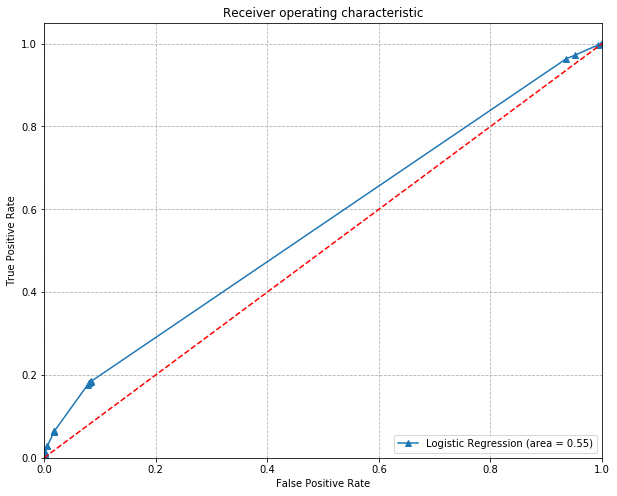

In [48]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
# print(roc_curve(y_test, lg.predict_proba(X_test)[:,1]))
fig, axes = plt.subplots(figsize=(10, 8))
axes.plot(fpr, tpr, marker='^', label='Logistic Regression (area = {:.2f})'.format(logit_roc_auc))
axes.plot([0, 1], [0, 1],'r--')
axes.set_xlim([0.0, 1.0])
axes.set_ylim([0.0, 1.05])
axes.set_xlabel('False Positive Rate')
axes.set_ylabel('True Positive Rate')
axes.set_title('Receiver operating characteristic')
axes.legend(loc="lower right")
plt.grid(True, linestyle='--');